# complex maps task
- named after complex span task
- trial consists of 3 phases
    - instruction phase, as dual PM task
    - OG phase, where the network knows to perform OG task
    - maps phase, where the network performs pure PM task


### in conversation with Ken:
- the only reason to use a dual PM is to keep WM busy with OG task
- mainly interested in development of buckets under EM strategy 

In [3]:
from glob import glob as glob
import itertools

import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *
from helperfuns_dualPM import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load net, eval

In [49]:
NBACK = 2
BEGIN_MAPS = 10

In [50]:
def load_net(seed):
  net = NetDualPM(stsize=20,emsetting=1,seed=seed)
  fpath = 'model_data/complex_maps_sweep1/'
  fpath += "LSTM20-EM1-nback_%i-pm_maps_3-seed_%i-model.pt"%(NBACK,seed)
  net.load_state_dict(tr.load(fpath))
  return net

In [55]:
num_subs = 2
trial_len = 30
fulltrial_len = trial_len+3
num_trials = 3

evacc = -np.ones([num_subs,2,fulltrial_len*num_trials])
for seed in range(num_subs):
  try: 
    net = load_net(seed)
  except: continue
  for em in [0,1]:
    net.EMsetting = em
    # task must have same seed becuase fixed stim set
    task = TaskDualPM(num_back=NBACK,pm_maps=3,seed=seed)
    gen_data_fn = lambda : task.gen_ep_data(
                        num_trials=num_trials,
                        trial_len=trial_len,
                        pm_probe_positions=np.arange(BEGIN_MAPS,trial_len))
    net_evacc = eval_net(net,task,neps=500,gen_data_fn=gen_data_fn,return_states=False)
    evacc[seed,em] = net_evacc
evacc = np.stack(evacc).reshape([num_subs,2,num_trials,fulltrial_len])

In [69]:
def plt_sub_evacc(ax,sub_evacc):
  """ sub_evacc [em(0,1),trial,trlen]
  """
  ax.set_ylim(0.2,1.05)
  ax.axhline(0.33,c='darkgreen',ls='--',lw=.5)
  ax.axvline(BEGIN_MAPS,c='purple')
  _,ntrials,trlen = sub_evacc.shape
  sub_evacc = sub_evacc[:,:,3:]
  for tr in range(ntrials):
    acc0 = sub_evacc[0,tr]
    acc1 = sub_evacc[1,tr]
    ax.plot(acc0,c=plt.cm.Reds((tr+2)/6))
    ax.plot(acc1,c=plt.cm.Blues((tr+2)/6))
    

3
3


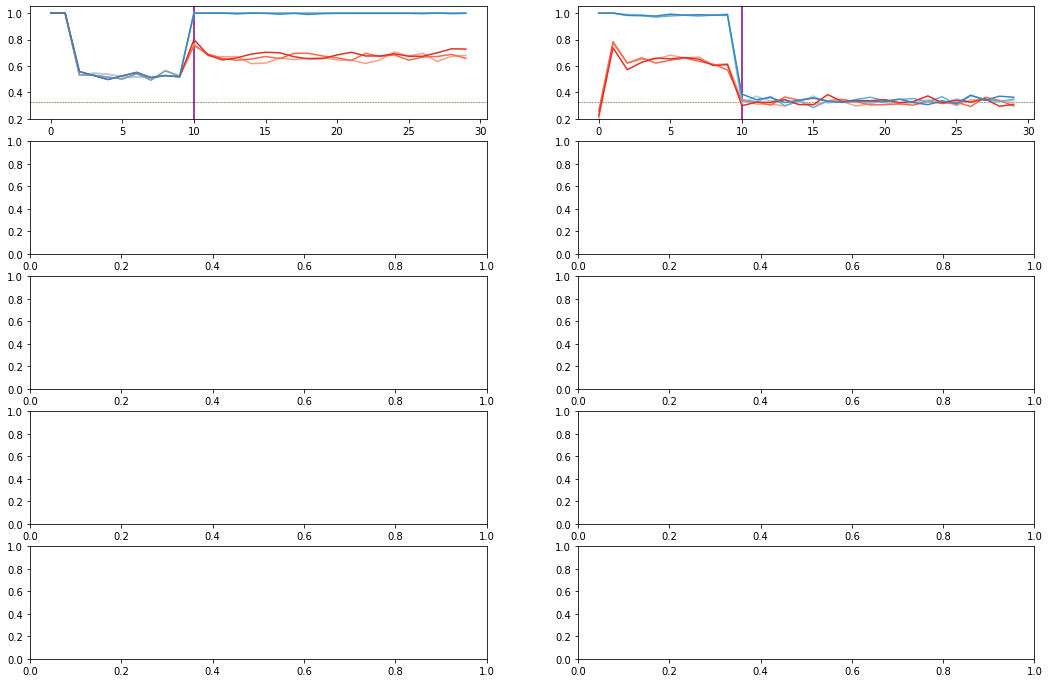

In [71]:
fig,axarr = plt.subplots(5,2,figsize=(18,12));axarr=axarr.reshape(-1)
for idx in range(num_subs):
  ax=axarr[idx]
  plt_sub_evacc(ax,evacc[idx])


# train and eval 

### init

In [26]:
# task sweep params
num_back = 1
pm_maps = 3 # number of maps active per trial
seed = 6
EMsetting = 1
## initialize
task = TaskDualPM(num_back=num_back,pm_maps=pm_maps,seed=seed)
net = NetDualPM(stsize=20,emsetting=EMsetting,seed=seed)

### train

In [27]:
## similar to a complex span task
gen_data_fn = lambda : task.gen_ep_data(num_trials=4,trial_len=10,pm_probe_positions=np.arange(5,10))
tr_acc = train_net(net,task,neps=100000,gen_data_fn=gen_data_fn,verb=True)

0.0 117.90936
0.2 23.37103
0.4 21.916426
0.6 24.321117
0.8 28.606827


(0, 1)

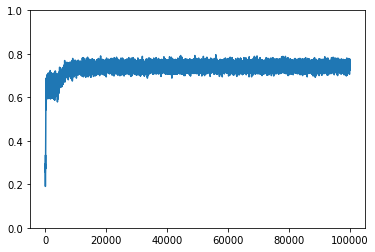

In [28]:
plt.plot(mov_avg(tr_acc,10))
plt.ylim(0,1)

### eval

In [11]:
gen_data_fn = lambda : task.gen_ep_data(num_trials=4,trial_len=7,pm_probe_positions=np.arange(5,7))
net.EMsetting=1
evacc = eval_net2(net,task,1000,gen_data_fn)

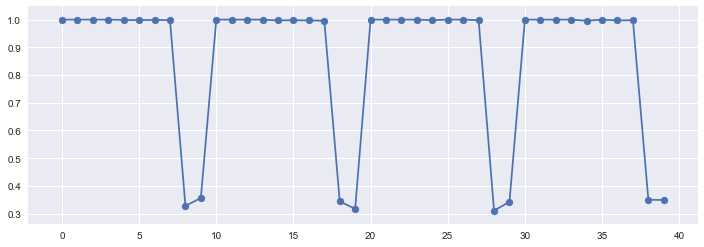

In [12]:
plt.figure(figsize=(12,4))
plt.plot(evacc)
plt.scatter(range(len(evacc)),evacc)
